Fitting 5 folds for each of 12 candidates, totalling 60 fits


[I 2024-10-17 11:16:19,427] A new study created in memory with name: no-name-bfb145f8-3f02-43d0-aa35-8a2ce6e35056
[I 2024-10-17 11:16:23,781] Trial 0 finished with value: 0.19633545291881385 and parameters: {'n_estimators': 161, 'learning_rate': 0.10593151438807637, 'max_depth': 6, 'subsample': 0.9463150405392392}. Best is trial 0 with value: 0.19633545291881385.
[I 2024-10-17 11:16:28,902] Trial 1 finished with value: 0.20160450803249547 and parameters: {'n_estimators': 270, 'learning_rate': 0.1605979971194339, 'max_depth': 6, 'subsample': 0.7729932581079071}. Best is trial 0 with value: 0.19633545291881385.
[I 2024-10-17 11:16:36,273] Trial 2 finished with value: 0.22508011082867138 and parameters: {'n_estimators': 268, 'learning_rate': 0.295645427928811, 'max_depth': 10, 'subsample': 0.6136245617729111}. Best is trial 0 with value: 0.19633545291881385.
[I 2024-10-17 11:16:38,376] Trial 3 finished with value: 0.21791607084769432 and parameters: {'n_estimators': 152, 'learning_rate': 

+--------------------------------+----------+----------+
| Model                          |      MSE |       R² |
+================================+==========+==========+
| Gradient Boosting (GridSearch) | 0.246841 | 0.999208 |
+--------------------------------+----------+----------+
| Gradient Boosting (Optuna)     | 0.225040 | 0.999278 |
+--------------------------------+----------+----------+


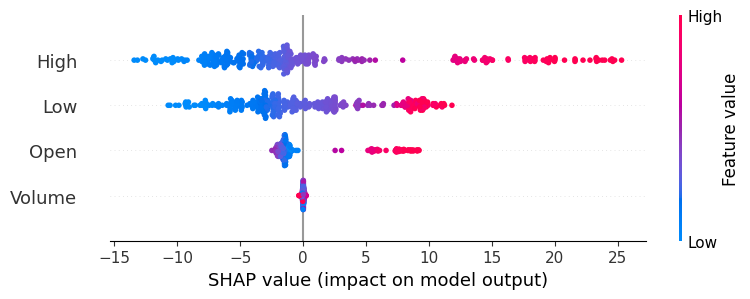

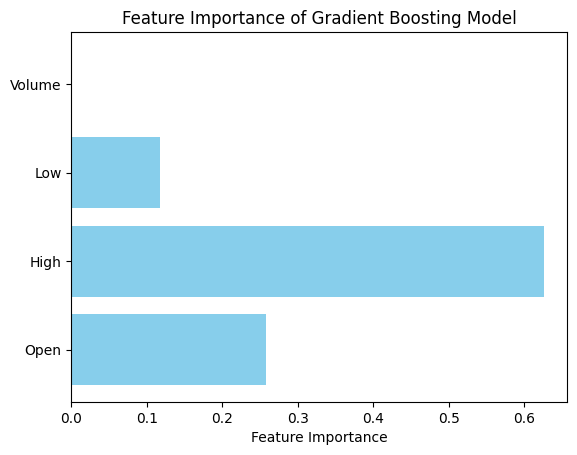

Воспроизводимость решения обеспечена с использованием random_state=42.


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tabulate import tabulate
!pip install optuna
import optuna
import shap

# 1. Подготовка данных
df = pd.read_csv('/content/Золото.csv')

# Выбор признаков и целевой переменной
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'

df_cleaned = df.dropna(subset=features + [target])

# Разделение данных на обучающую и тестовую выборки
X = df_cleaned[features]
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Базовая модель: Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# 3. Подбор гиперпараметров с GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_gbr = grid_search.best_estimator_
y_pred_best_gbr = best_gbr.predict(X_test)
gbr_mse = mean_squared_error(y_test, y_pred_best_gbr)
gbr_r2 = r2_score(y_test, y_pred_best_gbr)

# 4. Подбор гиперпараметров с Optuna
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0)
    }

    model = GradientBoostingRegressor(random_state=42, **param)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return -score.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params_optuna = study.best_params
optuna_gbr = GradientBoostingRegressor(random_state=42, **best_params_optuna)
optuna_gbr.fit(X_train, y_train)

y_pred_optuna_gbr = optuna_gbr.predict(X_test)
optuna_gbr_mse = mean_squared_error(y_test, y_pred_optuna_gbr)
optuna_gbr_r2 = r2_score(y_test, y_pred_optuna_gbr)

# 5. Вывод результатов
results = [
    ['Gradient Boosting (GridSearch)', gbr_mse, gbr_r2],
    ['Gradient Boosting (Optuna)', optuna_gbr_mse, optuna_gbr_r2]
]

headers = ['Model', 'MSE', 'R²']
print(tabulate(results, headers=headers, tablefmt='grid', floatfmt=".6f"))

# 6. Интерпретация модели с использованием SHAP
explainer = shap.Explainer(optuna_gbr, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

# 7. График важности признаков (барплот)
feature_importance = optuna_gbr.feature_importances_
plt.barh(X_train.columns, feature_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance of Gradient Boosting Model")
plt.show()

# Воспроизводимость решения обеспечена с использованием random_state=42.